In [74]:
import os, logging, gensim
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib import cm
import gensim

In [2]:
# Global configuration
lang = 'English'
root_path = '/home/sying/Documents/Decorrelation/' + lang + '/'

if lang == 'French':
    sim_model_path = root_path + 'wolf_15k_850d.txt'
    mix_model_path = root_path + 'depglove_200d_eric.txt'
    asn_model_path = root_path + 'asn_embedding.txt'
    sig_model_path = root_path + 'sig_embedding.txt'
elif lang == 'English':
    sim_model_path = root_path + 'sim_embedding.txt'
    mix_model_path = root_path + 'glove_840B_300d.txt'
    asn_model_path = root_path + 'asn_embedding.txt'
    sig_model_path = root_path + 'sig_embedding.txt'


In [80]:
# Word Alignment in two embeddings
file = open(sim_model_path, mode='r')
voc, dim = file.readline().split(' ')
voc = int(voc)
dim_sim = int(dim)

file_data = file.readlines()
file.close()

vocabulary = dict()
idx = 0
sim_model = np.zeros((voc, dim_sim), dtype=np.float32)
word_list = []

for line in file_data:
    vector = line.split(' ')
    word_list.append(vector[0])
    vocabulary[vector[0]] = idx
    sim_model[idx,:] = vector[1:]
    idx += 1

In [51]:
sim_model_origin = np.load('/home/sying/Documents/WordNetEmbeddings/data/output_230119/Normalized_random_walk.npy')

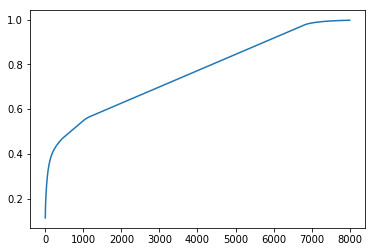

In [107]:
pca = PCA(n_components=8000, svd_solver='randomized')
pca_sim_o = pca.fit(sim_model_origin)
var_cum = np.cumsum(pca_sim_o.explained_variance_ratio_)
plt.plot(var_cum)
plt.plot(pca_sim_o.explained_variance_ratio_)

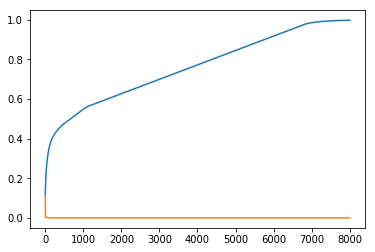

In [123]:
plt.plot(var_cum)
plt.plot(pca_sim_o.explained_variance_ratio_)

In [122]:
np.argmin(pca_sim_o.explained_variance_ratio_ > 0.0008)

109

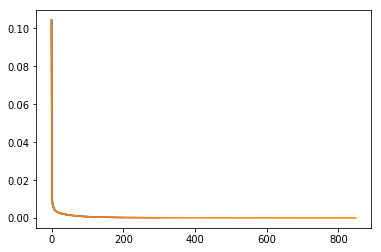

In [71]:
for idx, pca in enumerate(pca_list):
    plt.plot(pca.explained_variance_, c=cm.Set1.colors[idx], label=pca)
#plt.legend()
plt.show()

In [92]:
for dim in [1, 3, 5, 10, 20, 40]: # 50, 100, 200, 300, 800
    pca = PCA(n_components=dim, svd_solver='randomized')
    pca_sim_o = pca.fit_transform(sim_model_origin)
    file = open(root_path + 'sim_15k_'+ str(dim) +'d.txt', mode='w+')
    file.write('15000 ' + str(dim) + '\n')
    for idx, word in enumerate(word_list):
        file.write(word + ' ')
        file.write(' '.join(map(str, pca_sim_o[idx])))
        file.write('\n')
    file.close()

In [95]:
score_evo = {
    "wordsim_rel.csv": [],
    "simlex999.csv": []
}

In [96]:
ref_model = ["wordsim_rel.csv", "simlex999.csv"]

for dim in [1, 3, 5, 10, 20, 40, 50, 100, 200, 300, 800]: 
    model = gensim.models.KeyedVectors.load_word2vec_format(root_path + 'sim_15k_'+ str(dim) +'d.txt', binary=False)
    for ref in ref_model:
        print ("ref: %s---dim: %d---------------------"%(ref, dim))
        refp = "/home/sying/Documents/WordNetEmbeddings/data/input/English_testset/" + ref
        res = model.evaluate_word_pairs(refp, delimiter=';')
        print("Pearson, r", res[0][0], 'p', res[0][1])
        print("Spearman, r", res[1][0], 'p', res[1][1])     
        score_evo[ref].append(res[1][0])
        # print("OOV", res[2])        

ref: wordsim_rel.csv---dim: 1---------------------
Pearson, r -0.028923297307265075 p 0.6516810015999543
Spearman, r -0.02731437236332027 p 0.6698843299700079
ref: simlex999.csv---dim: 1---------------------
Pearson, r 0.0928559065481487 p 0.003339586656018638
Spearman, r 0.09242353672122837 p 0.0034902816674589445
ref: wordsim_rel.csv---dim: 3---------------------
Pearson, r -0.1147370630683565 p 0.07243858520218825
Spearman, r -0.12674279203416902 p 0.0470584861824747
ref: simlex999.csv---dim: 3---------------------
Pearson, r 0.17847960435359886 p 1.3942247171809345e-08
Spearman, r 0.2034355852047033 p 8.96800074474767e-11
ref: wordsim_rel.csv---dim: 5---------------------
Pearson, r -0.08838897190236404 p 0.1669802124737106
Spearman, r -0.08805512202560013 p 0.16859509561157598
ref: simlex999.csv---dim: 5---------------------
Pearson, r 0.2297706480775799 p 2.065932941356539e-13
Spearman, r 0.2549544588985472 p 2.942848659254214e-16
ref: wordsim_rel.csv---dim: 10-------------------

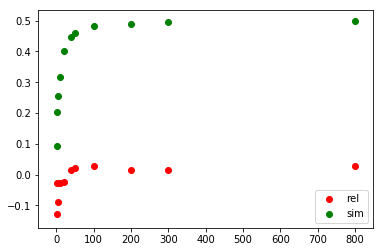

In [98]:
dims = [1, 3, 5, 10, 20, 40, 50, 100, 200, 300, 800]
plt.scatter(dims, score_evo['wordsim_rel.csv'], c='r', label='rel')
plt.scatter(dims, score_evo['simlex999.csv'], c='g', label='sim')
plt.legend()

In [5]:
if lang == 'French':
    file = open(mix_model_path, mode='r', encoding="cp1252")
if lang == 'English':
    file = open(mix_model_path, mode='r')
file_data = file.readlines()
file.close()

In [16]:
if lang == 'English':
    dim_mix = len(file_data[0].split(' ')) - 1
    #mix_model = np.zeros((voc, dim_mix), dtype=np.float32)
    for line in file_data:
        vector = line.split(' ', 1)
        try:
            idx = vocabulary.pop(vector[0])
            #mix_model[idx,:] = vector[1:]
        except KeyError:
            continue
            
elif lang == 'French':
    dim_mix = int(file_data[1])
    mix_model = np.zeros((voc, dim_mix), dtype=np.float32)
    
    for line in file_data[2:]:
        vector = line.split(' ')
        word = vector[0].split(':')[0]
        try:
            idx = vocabulary.pop(word)
            mix_model[idx,:] = vector[1:]
        except KeyError:
            continue
        

In [19]:
voc - len(vocabulary)

8157

In [ ]:
vocabulary_mask = np.ones(voc, dtype=np.bool)
vocabulary_mask[list(vocabulary.values())] = 0

sim_model_red = sim_model[vocabulary_mask,:]
mix_model_red = mix_model[vocabulary_mask,:]

In [ ]:
# Linear Decorrelation by projecting A emb. onto B emb.

reg = linear_model.LinearRegression()
reg.fit(sim_model_red, mix_model_red)
score = reg.score(sim_model_red, mix_model_red)
print("Model mapping score: ", score)

asn_model_red = mix_model_red - reg.predict(sim_model_red)
word_list = [word_list[i] for i in range(len(word_list)) if vocabulary_mask[i]]
file = open(asn_model_path, mode='w')
file.write('{} {}\n'.format(len(word_list), dim_mix))
asn_model_df = pd.DataFrame(asn_model_red, index=word_list)
file.write(asn_model_df.to_csv(sep=' ', header=False))
file.close()

file = open(sig_model_path, mode='w')
file.write('{} {}\n'.format(len(word_list), dim_mix))
sig_model_red = reg.predict(sim_model_red)
sig_model_df = pd.DataFrame(sig_model_red, index=word_list)
file.write(sig_model_df.to_csv(sep=' ', header=False))
file.close()


# De correlation check

In [6]:
sim_model.shape

(15000, 850)

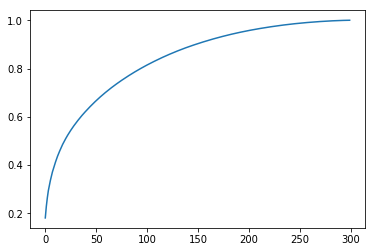

In [136]:
pca = PCA(n_components=300, svd_solver='full')
pca.fit(sig_model)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

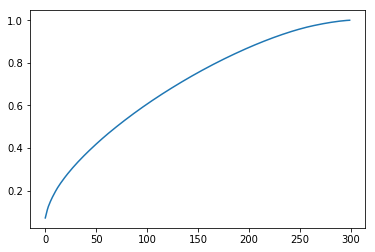

In [137]:
pca = PCA(n_components=300, svd_solver='full')
pca.fit(asn_model)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

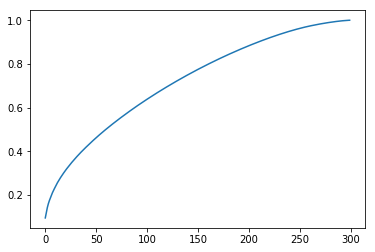

In [138]:
pca = PCA(n_components=300, svd_solver='full')
pca.fit(asn_model+sig_model)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [139]:
len(word_list)

8157

In [140]:
for dim in [1, 3, 5, 10, 20, 40, 50, 100, 200, 300]: # 50, 100, 200, 300, 800
    pca = PCA(n_components=dim, svd_solver='full')
    pca_sim_o = pca.fit_transform(sig_model)
    file = open(root_path + 'sig_'+ str(dim) +'d.txt', mode='w+')
    file.write('8157 ' + str(dim) + '\n')
    for idx, word in enumerate(word_list):
        file.write(word + ' ')
        file.write(' '.join(map(str, pca_sim_o[idx])))
        file.write('\n')
    file.close()

In [141]:
score_evo = {
    "wordsim_rel.csv": [],
    "simlex999.csv": []
}

In [142]:
ref_model = ["wordsim_rel.csv", "simlex999.csv"]

for dim in [1, 3, 5, 10, 20, 40, 50, 100, 200, 300]: 
    model = gensim.models.KeyedVectors.load_word2vec_format(root_path + 'sig_'+ str(dim) +'d.txt', binary=False)
    for ref in ref_model:
        print ("ref: %s---dim: %d---------------------"%(ref, dim))
        refp = "/home/sying/Documents/WordNetEmbeddings/data/input/English_testset/" + ref
        res = model.evaluate_word_pairs(refp, delimiter=';')
        print("Pearson, r", res[0][0], 'p', res[0][1])
        print("Spearman, r", res[1][0], 'p', res[1][1])     
        score_evo[ref].append(res[1][0])
        # print("OOV", res[2])        

ref: wordsim_rel.csv---dim: 1---------------------
Pearson, r -0.056527349919642214 p 0.3773512024430653
Spearman, r -0.06305081278724561 p 0.3246943813383527
ref: simlex999.csv---dim: 1---------------------
Pearson, r 0.0797900002201284 p 0.011727075467404128
Spearman, r 0.07828444789378097 p 0.013415298601460705
ref: wordsim_rel.csv---dim: 3---------------------
Pearson, r 0.013924487966183133 p 0.8279782577426049
Spearman, r 0.015312108663798098 p 0.8111429137370983
ref: simlex999.csv---dim: 3---------------------


/home/sying/root/anaconda3/envs/micipsa/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Pearson, r 0.1944246204781682 p 5.998106486212629e-10
Spearman, r 0.2390851064450013 p 1.9951453847966138e-14
ref: wordsim_rel.csv---dim: 5---------------------
Pearson, r 0.04386672854489525 p 0.4934396807917223
Spearman, r 0.05930570331116747 p 0.3543152498636163
ref: simlex999.csv---dim: 5---------------------
Pearson, r 0.22627280100743427 p 4.842850086752783e-13
Spearman, r 0.2918327635830221 p 5.022651115410627e-21
ref: wordsim_rel.csv---dim: 10---------------------
Pearson, r 0.06650819245246309 p 0.29881491914382907
Spearman, r 0.07588985764337688 p 0.23564816665548333
ref: simlex999.csv---dim: 10---------------------
Pearson, r 0.28034347833740114 p 1.840831020398104e-19
Spearman, r 0.3583062009384516 p 1.437823105395034e-31
ref: wordsim_rel.csv---dim: 20---------------------
Pearson, r 0.10115821015510085 p 0.11351590782196165
Spearman, r 0.118539259545451 p 0.06341132762347461
ref: simlex999.csv---dim: 20---------------------
Pearson, r 0.32832285525210725 p 1.73393224383550

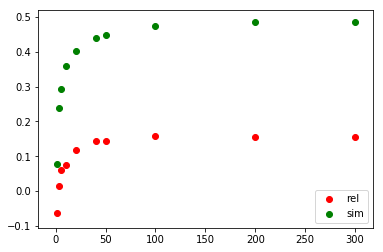

In [144]:
dims = [1, 3, 5, 10, 20, 40, 50, 100, 200, 300]
plt.scatter(dims, score_evo['wordsim_rel.csv'], c='r', label='rel')
plt.scatter(dims, score_evo['simlex999.csv'], c='g', label='sim')
plt.legend()

In [145]:
for dim in [1, 3, 5, 10, 20, 40, 50, 100, 200, 300]: # 50, 100, 200, 300, 800
    pca = PCA(n_components=dim, svd_solver='full')
    pca_sim_o = pca.fit_transform(asn_model)
    file = open(root_path + 'asn_'+ str(dim) +'d.txt', mode='w+')
    file.write('8157 ' + str(dim) + '\n')
    for idx, word in enumerate(word_list):
        file.write(word + ' ')
        file.write(' '.join(map(str, pca_sim_o[idx])))
        file.write('\n')
    file.close()

In [146]:
score_evo = {
    "wordsim_rel.csv": [],
    "simlex999.csv": []
}

In [147]:
ref_model = ["wordsim_rel.csv", "simlex999.csv"]

for dim in [1, 3, 5, 10, 20, 40, 50, 100, 200, 300]: 
    model = gensim.models.KeyedVectors.load_word2vec_format(root_path + 'asn_'+ str(dim) +'d.txt', binary=False)
    for ref in ref_model:
        print ("ref: %s---dim: %d---------------------"%(ref, dim))
        refp = "/home/sying/Documents/WordNetEmbeddings/data/input/English_testset/" + ref
        res = model.evaluate_word_pairs(refp, delimiter=';')
        print("Pearson, r", res[0][0], 'p', res[0][1])
        print("Spearman, r", res[1][0], 'p', res[1][1])     
        score_evo[ref].append(res[1][0])
        # print("OOV", res[2])        

ref: wordsim_rel.csv---dim: 1---------------------
Pearson, r 0.10553742564304748 p 0.09864177007304509
Spearman, r 0.12465104909392706 p 0.05085037560496529
ref: simlex999.csv---dim: 1---------------------
Pearson, r -0.06423230366384403 p 0.042590408621556775
Spearman, r -0.06419415978390189 p 0.042713783070042824
ref: wordsim_rel.csv---dim: 3---------------------
Pearson, r 0.19199597339564733 p 0.0024930244615243334
Spearman, r 0.23424906389690725 p 0.0002096871618163823
ref: simlex999.csv---dim: 3---------------------


/home/sying/root/anaconda3/envs/micipsa/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Pearson, r -0.05893010177311525 p 0.0628829227459501
Spearman, r -0.044049834184541746 p 0.16458451022111
ref: wordsim_rel.csv---dim: 5---------------------
Pearson, r 0.19952729358519838 p 0.001659675835204111
Spearman, r 0.25711968726910767 p 4.4833247674864805e-05
ref: simlex999.csv---dim: 5---------------------
Pearson, r -0.0367591064104622 p 0.24620521557822495
Spearman, r -0.0280459092128802 p 0.37636092667254506
ref: wordsim_rel.csv---dim: 10---------------------
Pearson, r 0.2920212728270038 p 3.1806914955017443e-06
Spearman, r 0.3289390793848274 p 1.287529346770378e-07
ref: simlex999.csv---dim: 10---------------------
Pearson, r -0.013301051441778929 p 0.6748679467665855
Spearman, r -0.00479528531505707 p 0.8797993897929733
ref: wordsim_rel.csv---dim: 20---------------------
Pearson, r 0.3390586864648829 p 4.946307156429529e-08
Spearman, r 0.37804262174579595 p 8.893763403277865e-10
ref: simlex999.csv---dim: 20---------------------
Pearson, r 0.01411665849659504 p 0.656174623

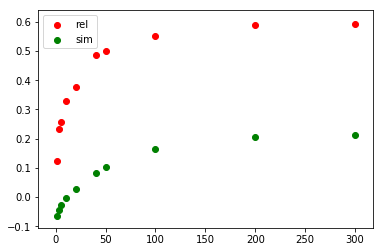

In [148]:
dims = [1, 3, 5, 10, 20, 40, 50, 100, 200, 300]
plt.scatter(dims, score_evo['wordsim_rel.csv'], c='r', label='rel')
plt.scatter(dims, score_evo['simlex999.csv'], c='g', label='sim')
plt.legend()

In [133]:
file = open(sig_model_path, mode='r')
voc, dim = file.readline().split(' ')
voc = int(voc)
dim_sim = int(dim)

file_data = file.readlines()
file.close()

vocabulary = dict()
idx = 0
sig_model = np.zeros((voc, dim_sim), dtype=np.float32)
word_list = []

for line in file_data:
    vector = line.split(' ')
    word_list.append(vector[0])
    vocabulary[vector[0]] = idx
    sig_model[idx,:] = vector[1:]
    idx += 1

In [134]:
file = open(asn_model_path, mode='r')
voc, dim = file.readline().split(' ')
voc = int(voc)
dim_sim = int(dim)

file_data = file.readlines()
file.close()

idx = 0
asn_model = np.zeros((voc, dim_sim), dtype=np.float32)

for line in file_data:
    vector = line.split(' ')
    asn_model[idx,:] = vector[1:]
    idx += 1

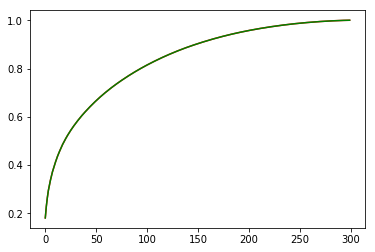

In [135]:
plt.plot(np.cumsum(pca_sig.explained_variance_ratio_), c='r')
plt.plot(np.cumsum(pca_asn.explained_variance_ratio_), c='g')
plt.show()

In [25]:
asn_sig_corr = asn_model_df.corrwith(sig_model_df, method='spearman', axis=0) 

In [26]:
len(word_list)

635

In [3]:
# Extract vocabulary
file = open(sim_model_path, mode='r')
voc, dim = file.readline().split(' ')
voc = int(voc)
dim_sim = int(dim)


file_data = file.readlines()
file.close()

vocabulary = dict()
idx = 0
word_list = []

for line in file_data:
    vector = line.split(' ')
    word_list.append(vector[0])
    vocabulary[vector[0]] = idx


In [6]:
voc_file_path = root_path + 'sim_vocabulary.txt'
file = open(voc_file_path, mode='w')
file.write('\n'.join(list(vocabulary.keys())))
file.close()
     

In [7]:
file = open(mix_model_path, mode='r', encoding="cp1252")
file_data = file.readlines()
file.close()

voc_file_path = root_path + 'mix_vocabulary.txt'
file = open(voc_file_path, mode='w')


for line in file_data[2:]:
    vector = line.split(' ')
    word = vector[0].split(':')[0]
    file.write(word+'\n')
    
file.close()
